# Binary Classification on the Edibility of Mushrooms
Students:
* _Andrea Pepe (matr. 0315903)_
* _Matteo Ciccaglione (matr. 0315944)_ 

This document presents the task of binary classification of mushrooms into the `edible` and `posionous` classes. The dataset is artificially generated starting from  a real dataset of the 1987, and has more than 60K entries representing mushrooms.
Elements have 15 features: 

In [1]:
import pandas as pd
import sklearn.naive_bayes
import sklearn.linear_model
import sklearn.discriminant_analysis
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
import matplotlib.colors as mcolors
plt.style.use('ggplot')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8

colors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c', 
'#137e6d', '#be0119', '#3b638c', '#af6f09', '#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', 
'#810f7c', '#137e6d', '#be0119', '#3b638c', '#af6f09']

cmap = mcolors.LinearSegmentedColormap.from_list("", ["#82cafc", "#069af3", "#0485d1", colors[0], colors[8]])

In [3]:
df = pd.read_csv("dataset/SecondaryData/secondary_data_no_miss.csv",sep=';')
df.head(15)

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
0,e,1.26,x,g,y,f,d,c,w,5.04,1.73,y,f,f,d,a
1,e,10.32,f,e,b,f,a,c,b,4.68,19.44,w,t,f,d,a
2,p,0.92,x,g,p,f,a,c,p,4.59,1.15,k,f,f,d,u
3,p,4.27,x,t,p,f,x,c,w,4.55,6.52,w,f,f,d,a
4,e,3.08,f,s,w,f,d,d,w,2.67,5.18,w,f,f,m,a
5,p,1.31,s,s,y,f,f,f,f,3.20,5.39,y,f,f,d,a
6,p,2.58,f,t,r,f,a,c,y,4.87,6.19,y,f,f,d,a
7,p,18.52,f,k,w,t,d,d,w,6.94,29.10,w,f,f,d,a
8,e,10.89,x,s,n,t,e,c,n,8.03,17.11,w,t,l,m,a
9,e,5.64,x,h,y,t,x,c,y,7.55,15.69,w,f,f,d,u


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 61069 non-null  object 
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-surface           61069 non-null  object 
 4   cap-color             61069 non-null  object 
 5   does-bruise-or-bleed  61069 non-null  object 
 6   gill-attachment       61069 non-null  object 
 7   gill-spacing          61069 non-null  object 
 8   gill-color            61069 non-null  object 
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-color            61069 non-null  object 
 12  has-ring              61069 non-null  object 
 13  ring-type             61069 non-null  object 
 14  habitat               61069 non-null  object 
 15  season             

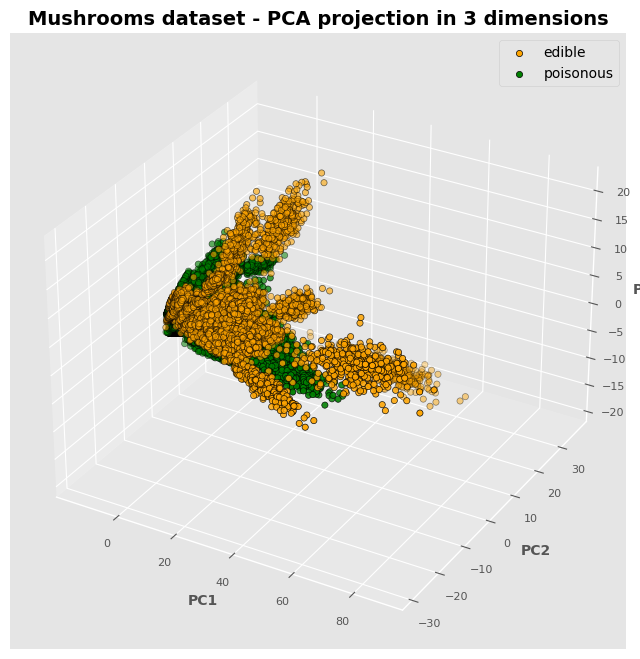

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

df_copy = df.copy()
class_labels = df_copy['class']
class_labels = np.where(class_labels == 'p', 'poisonous', 'edible') 

# Principal Component Analysis (PCA) to reduce the dimensionality of the dataset, in order to represent it in a 3D plot
pca = PCA(n_components=3)

le = LabelEncoder()
df_copy['class'] = le.fit_transform(df_copy['class'])
df_copy = pd.get_dummies(df_copy)

principal_components = pca.fit_transform(df_copy)

df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
df_pca['class'] = class_labels

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = {'edible': 'orange', 'poisonous': 'green'}

for class_label, color in colors.items():
    df_class = df_pca[df_pca['class'] == class_label]
    ax.scatter(df_class['PC1'], df_class['PC2'], df_class['PC3'], c=colors[class_label], edgecolor='black', label=class_label)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

ax.legend()
ax.set_title('Mushrooms dataset - PCA projection in 3 dimensions', fontsize=14, fontweight='bold')

plt.show()


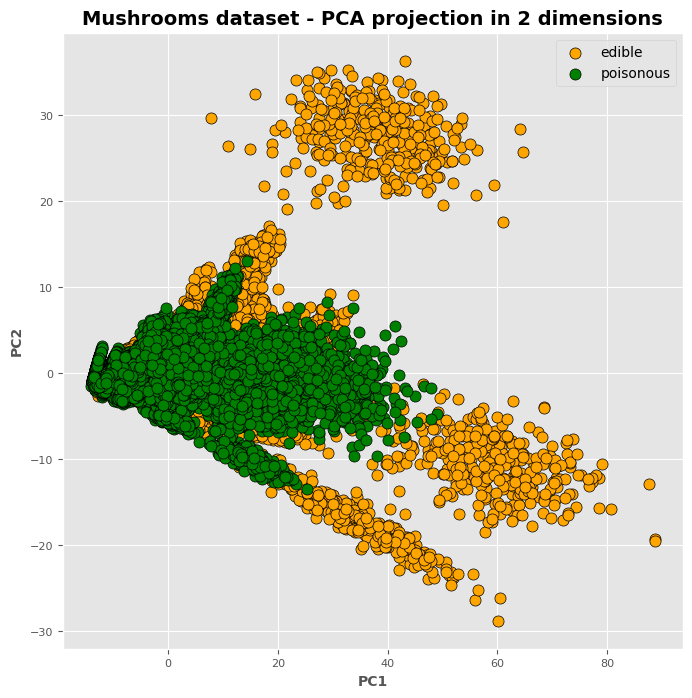

In [6]:
# Principal Component Analysis (PCA) to reduce the dimensionality of the dataset, in order to represent it in a 2D plot
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_copy)

df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
df_pca['class'] = class_labels

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

colors = {'edible': 'orange','poisonous': 'green'}

for class_label, color in colors.items():
    df_class = df_pca[df_pca['class'] == class_label]
    ax.scatter(df_class['PC1'], df_class['PC2'], c=colors[class_label], edgecolors='black', label=class_label)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend()
ax.set_title('Mushrooms dataset - PCA projection in 2 dimensions', fontsize=14, fontweight='bold')
plt.show()

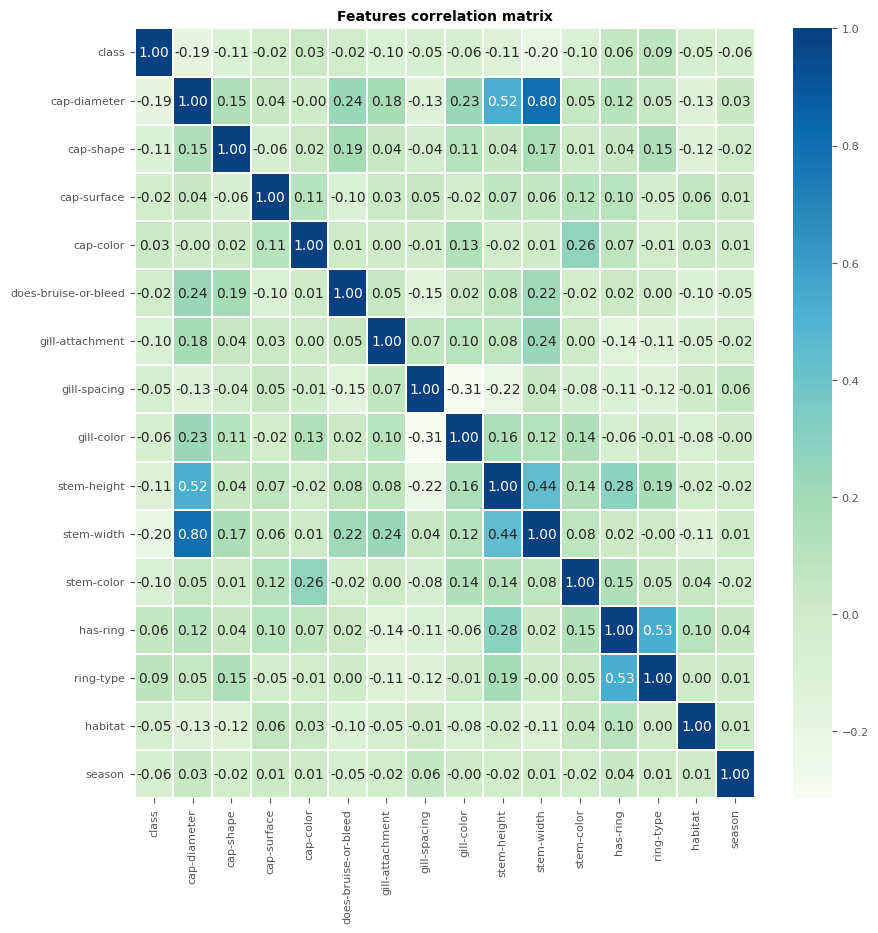

In [7]:
encoded_data = df.copy()
le = LabelEncoder()
encoded_data['class'] = le.fit_transform(df['class'])

for col in encoded_data.columns:
    encoded_data[col] = le.fit_transform(encoded_data[col])

dfDummies = encoded_data
plt.figure(figsize=(10,10))
sns.heatmap(dfDummies.corr(), linewidths=.3, cmap="GnBu", annot=True, fmt=".2f")
plt.title('Features correlation matrix', fontweight="bold")
plt.yticks(rotation=0)
plt.show()

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score

models = {}

## Logistic Regression

Logistic Regression is used for binary classification and defines a model which classifies items making regression. It's a Generalized Linear Model, that applies the non-linear sigmoidal function $\sigma$ to the linear combination of parameters with the input element's features:

$$
y(x) = \sigma(w \cdot x) = \frac{1}{1 + e^{-w \cdot x}}
$$

### 1-hot encoding
Since most of the feature of the training set are categorical, 1-hot encoding is required. It is done by invoking the Pandas' `get_dummies()` method.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

data = df.copy()
X = data.drop(columns=['class'])
y = data['class']
y = np.where(y == 'p', 'poisonous', 'edible')
# 1-hot encoding
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.20, random_state=100)
X.head(10)

,cap-diameter,stem-height,stem-width,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_o,cap-shape_p,cap-shape_s,cap-shape_x,...,habitat_h,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w,season_a,season_s,season_u,season_w
0,1.26,5.04,1.73,False,False,False,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
1,10.32,4.68,19.44,False,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,0.92,4.59,1.15,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
3,4.27,4.55,6.52,False,False,False,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
4,3.08,2.67,5.18,False,False,True,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
5,1.31,3.20,5.39,False,False,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
6,2.58,4.87,6.19,False,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
7,18.52,6.94,29.10,False,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
8,10.89,8.03,17.11,False,False,False,False,False,False,True,...,False,False,True,False,False,False,True,False,False,False
9,5.64,7.55,15.69,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False


In [10]:
import json
# Logistic regression fitting
class_weight = {'edible': 1, 'poisonous': 1} # balanced class weights
logreg = LogisticRegression(solver='newton-cholesky', class_weight=class_weight, max_iter=1000)
logreg.fit(X_train, y_train)
pred = logreg.predict(X_test)
report = classification_report(y_test, pred)
print(f'Logistic Regression')
print(report)

Logistic Regression
              precision    recall  f1-score   support

      edible       0.74      0.75      0.74      5458
   poisonous       0.79      0.79      0.79      6756

    accuracy                           0.77     12214
   macro avg       0.77      0.77      0.77     12214
weighted avg       0.77      0.77      0.77     12214



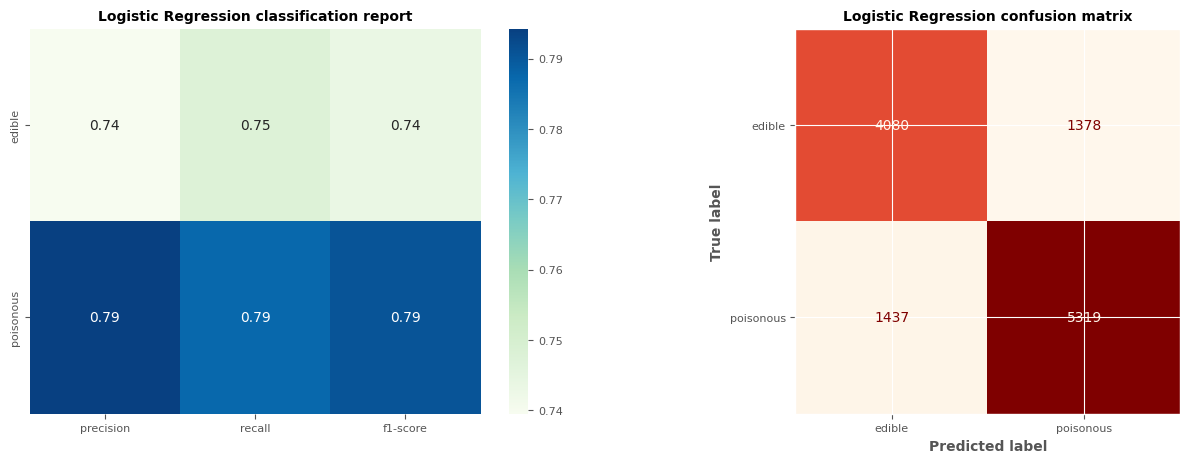

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

report = classification_report(y_test, pred, output_dict=True)
sns.heatmap(pd.DataFrame(report).iloc[:-1, :-3].T, annot=True, cmap="GnBu", ax=ax[0])
ax[0].set_title('Logistic Regression classification report', fontweight="bold")

ConfusionMatrixDisplay(confusion_matrix(y_test, pred), display_labels=['edible', 'poisonous']).plot(cmap='OrRd', ax=ax[1], colorbar=False)
ax[1].set_title('Logistic Regression confusion matrix', fontweight="bold")
plt.show()

In [12]:
from sklearn.model_selection import KFold
from sklearn.metrics import auc, roc_curve

def plot_ROC(model, X, y, n_folds=5, plot_folds=True, stdev=False):
    #skf = StratifiedKFold(n_splits=n_folds, shuffle=False)
    skf = KFold(n_splits=n_folds, shuffle=False)
    tprs = []
    aucs = []

    mean_fpr = np.linspace(0, 1, 100)
    i = 1
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)
        
        fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, 1], pos_label='poisonous')
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        if plot_folds:
            plt.plot(fpr, tpr, lw=2, alpha=0.4, label='ROC fold %d (AUC = %0.4f)' % (i, roc_auc))
        i = i+1

    mean_tpr = np.mean(tprs, axis=0)
    std_tpr = np.std(tprs, axis=0)

    mean_auc = 0.0
    for elem in aucs:
        mean_auc += elem
    mean_auc /= len(aucs)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, label=f'Mean ROC (AUC = {mean_auc:.4f} $\pm$ {std_auc:.4f})', color='k', alpha=1, lw=1.5)
    if stdev:
        plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='k', alpha=.3)

    #plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')

    #plt.show()

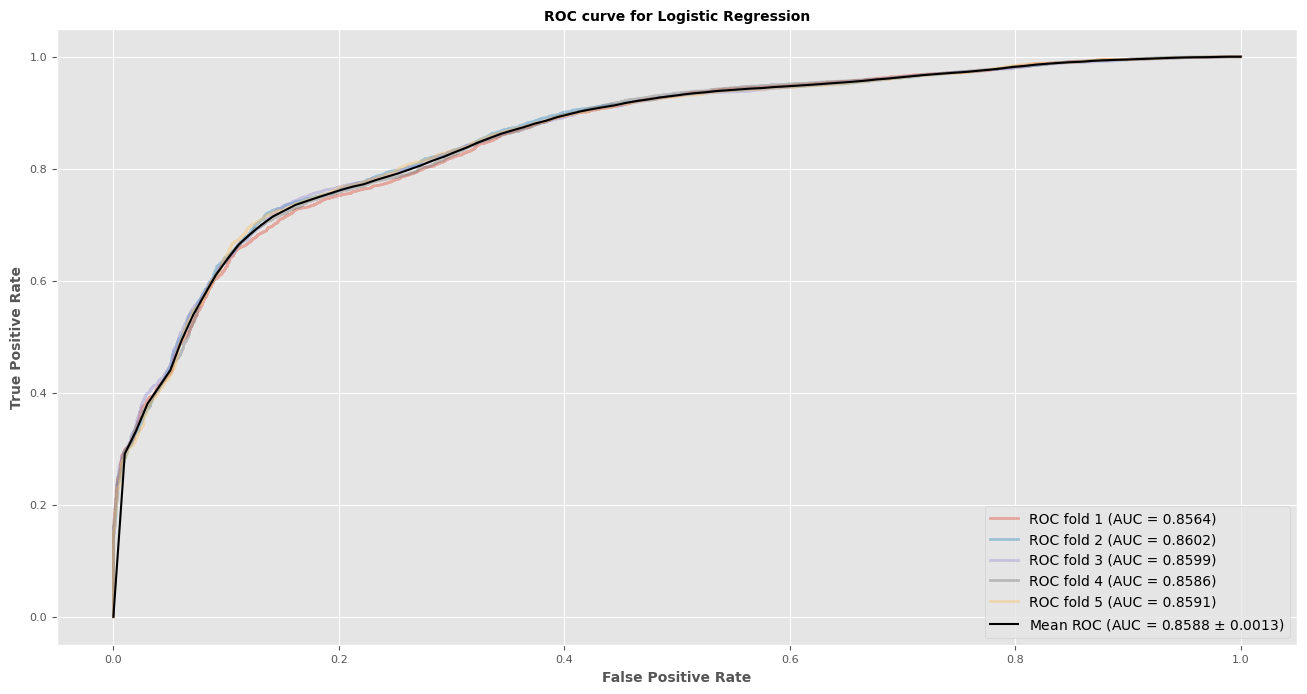

In [13]:
plot_ROC(logreg, X_train, y_train, n_folds=5, plot_folds=True, stdev=False)
plt.title('ROC curve for Logistic Regression', fontweight='bold')
plt.show()

In [14]:
item = {'model': logreg, 'accuracy': 0, 'precision': 0, 'recall': 0, 'f2': 0}
item['accuracy'] = accuracy_score(y_test, pred)
item['precision'] = precision_score(y_test, pred, pos_label='poisonous')
item['recall'] = recall_score(y_test, pred, pos_label='poisonous')
item['f2'] = fbeta_score(y_test, pred, beta=2, pos_label='poisonous')

models['Logistic Regression'] = item

## LDA - Linear Discriminant Analysis
This model uses the Fisher criterion measure to project points on a singular line trying to maximize the distance between the projections of the mean points of the 2 classes on such line, but, at the same time, minimizing the within-class variance, in order to have as lower dispersion as possible in the projections. 

In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
pred = lda.predict(X_test)
report = classification_report(y_test, pred)
print(f'Linear Discriminant Analysis')
print(report)

Linear Discriminant Analysis
              precision    recall  f1-score   support

      edible       0.74      0.75      0.75      5458
   poisonous       0.80      0.79      0.79      6756

    accuracy                           0.77     12214
   macro avg       0.77      0.77      0.77     12214
weighted avg       0.77      0.77      0.77     12214



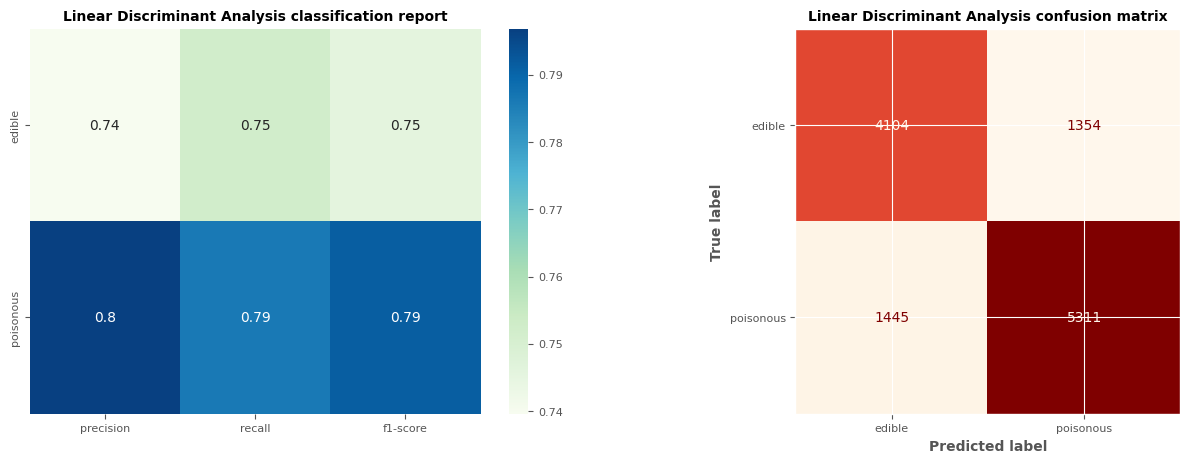

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

report = classification_report(y_test, pred, output_dict=True)
sns.heatmap(pd.DataFrame(report).iloc[:-1, :-3].T, annot=True, cmap="GnBu", ax=ax[0])
ax[0].set_title('Linear Discriminant Analysis classification report', fontweight="bold")

ConfusionMatrixDisplay(confusion_matrix(y_test, pred), display_labels=['edible', 'poisonous']).plot(cmap='OrRd', ax=ax[1], colorbar=False)
ax[1].set_title('Linear Discriminant Analysis confusion matrix', fontweight="bold")
plt.show()

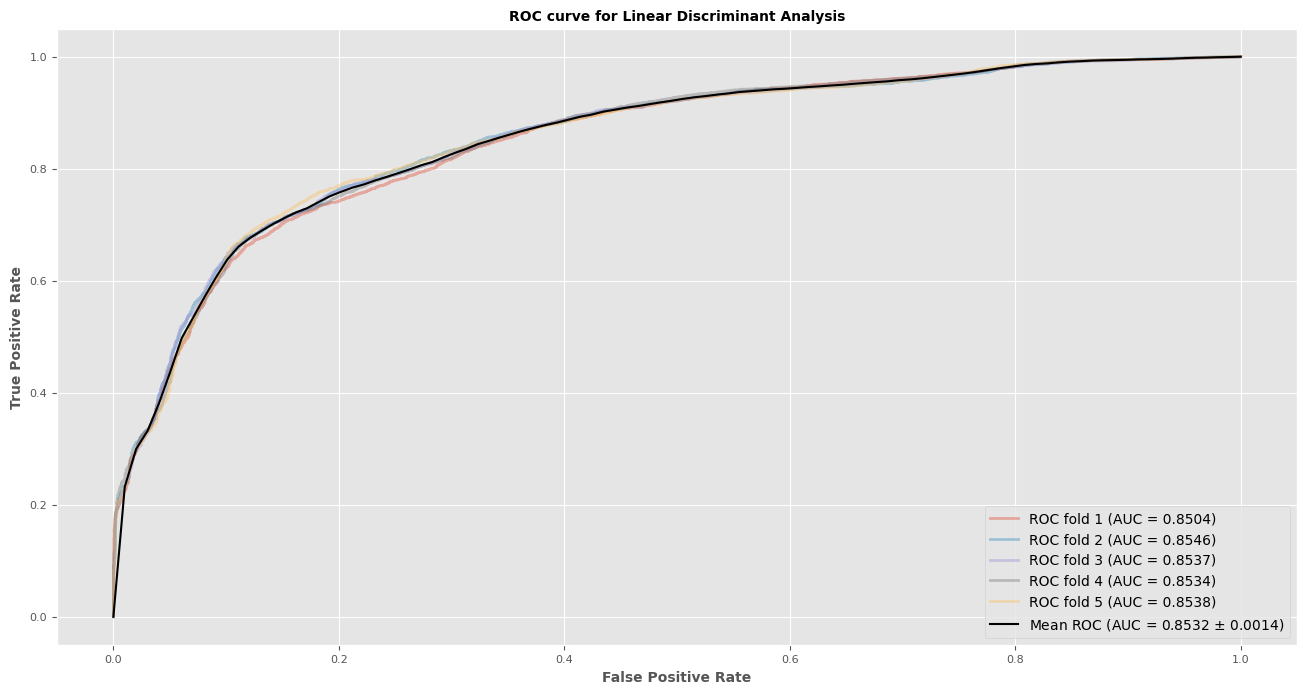

In [17]:
plot_ROC(lda, X_train, y_train, n_folds=5, plot_folds=True, stdev=False)
plt.title('ROC curve for Linear Discriminant Analysis', fontweight='bold')
plt.show()

In [18]:
item = {'model': lda, 'accuracy': 0, 'precision': 0, 'recall': 0, 'f2': 0}
item['accuracy'] = accuracy_score(y_test, pred)
item['precision'] = precision_score(y_test, pred, pos_label='poisonous')
item['recall'] = recall_score(y_test, pred, pos_label='poisonous')
item['f2'] = fbeta_score(y_test, pred, beta=2, pos_label='poisonous')

models['Linear Discriminant Analysis'] = item

## Naive Bayes
Naive Bayes classifier uses Bayesian approach to classification, inspired by generative langugae models.

In [19]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)
pred = nb.predict(X_test)
report = classification_report(y_test, pred)
print(f'Gaussian Naive Bayes')
print(report)

Gaussian Naive Bayes
              precision    recall  f1-score   support

      edible       0.69      0.63      0.66      5458
   poisonous       0.72      0.77      0.74      6756

    accuracy                           0.71     12214
   macro avg       0.70      0.70      0.70     12214
weighted avg       0.70      0.71      0.70     12214



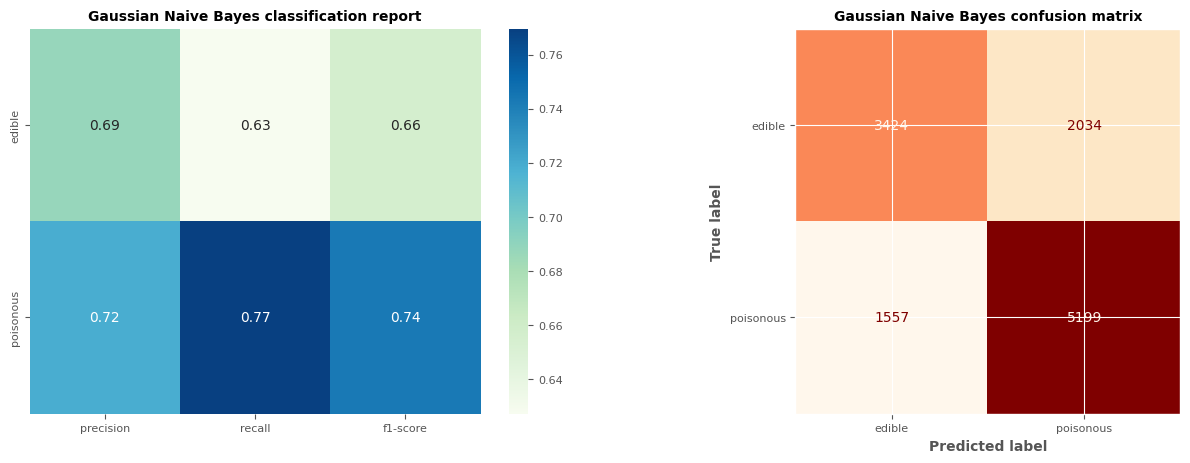

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

report = classification_report(y_test, pred, output_dict=True)
sns.heatmap(pd.DataFrame(report).iloc[:-1, :-3].T, annot=True, cmap="GnBu", ax=ax[0])
ax[0].set_title('Gaussian Naive Bayes classification report', fontweight="bold")

ConfusionMatrixDisplay(confusion_matrix(y_test, pred), display_labels=['edible', 'poisonous']).plot(cmap='OrRd', ax=ax[1], colorbar=False)
ax[1].set_title('Gaussian Naive Bayes confusion matrix', fontweight="bold")
plt.show()

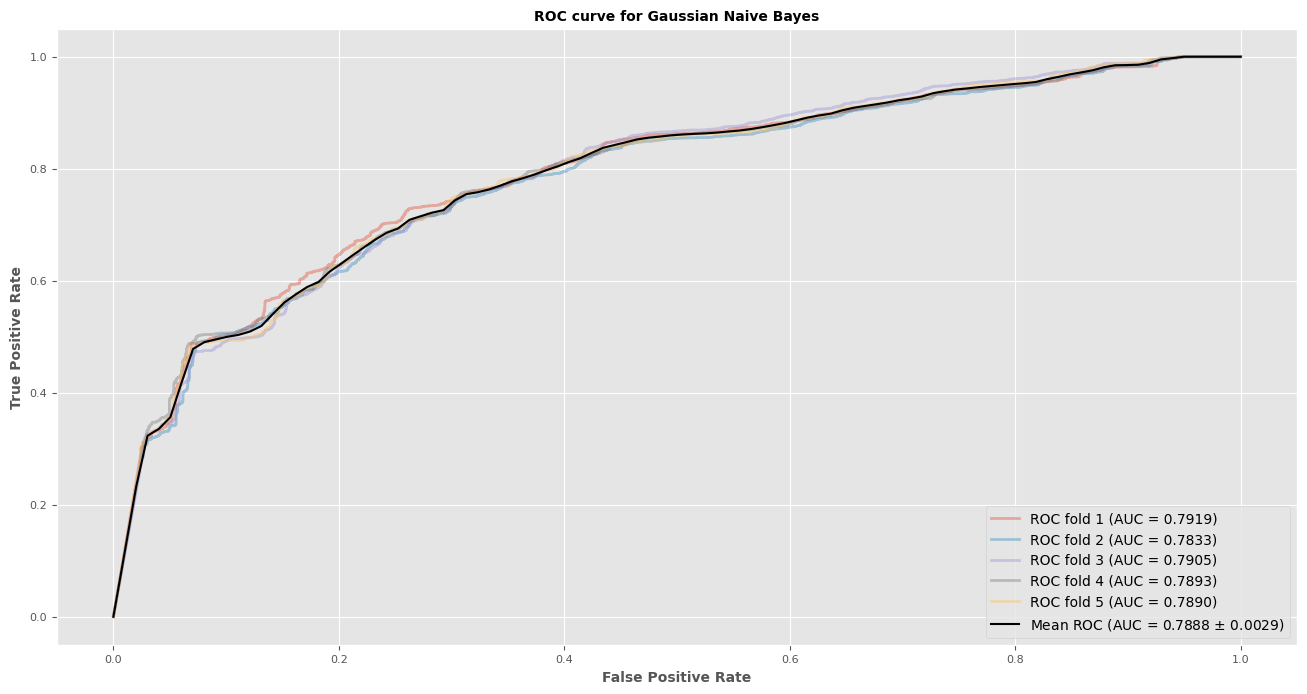

In [21]:
plot_ROC(nb, X_train, y_train, n_folds=5, plot_folds=True, stdev=False)
plt.title('ROC curve for Gaussian Naive Bayes', fontweight='bold')
plt.show()

In [22]:
item = {'model': nb, 'accuracy': 0, 'precision': 0, 'recall': 0, 'f2': 0}
item['accuracy'] = accuracy_score(y_test, pred)
item['precision'] = precision_score(y_test, pred, pos_label='poisonous')
item['recall'] = recall_score(y_test, pred, pos_label='poisonous')
item['f2'] = fbeta_score(y_test, pred, beta=2, pos_label='poisonous')

models['Naive Bayes'] = item

# Random Forest
This model uses ensemble methods to combine different poor and simple classifiers, in particular Decision Tree models. Their prediction are weighted and summed in a global one.

In [23]:
from sklearn.ensemble import RandomForestClassifier

# hyperparameters decided a priori
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
report = classification_report(y_test, pred)
print(f'Random Forest')
print(report)

Random Forest
              precision    recall  f1-score   support

      edible       0.88      0.77      0.82      5458
   poisonous       0.83      0.91      0.87      6756

    accuracy                           0.85     12214
   macro avg       0.85      0.84      0.85     12214
weighted avg       0.85      0.85      0.85     12214



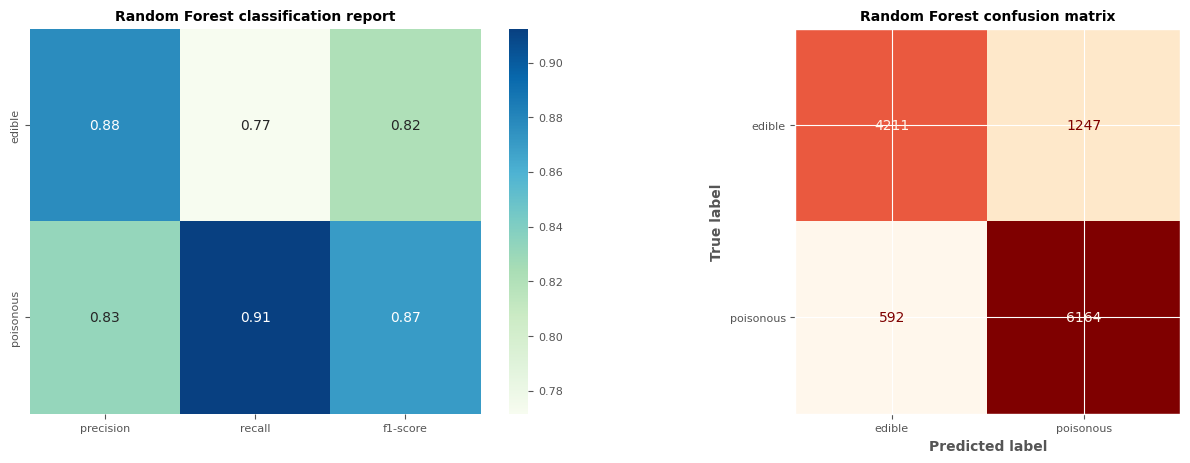

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

report = classification_report(y_test, pred, output_dict=True)
sns.heatmap(pd.DataFrame(report).iloc[:-1, :-3].T, annot=True, cmap="GnBu", ax=ax[0])
ax[0].set_title('Random Forest classification report', fontweight="bold")

ConfusionMatrixDisplay(confusion_matrix(y_test, pred), display_labels=['edible', 'poisonous']).plot(cmap='OrRd', ax=ax[1], colorbar=False)
ax[1].set_title('Random Forest confusion matrix', fontweight="bold")
plt.show()

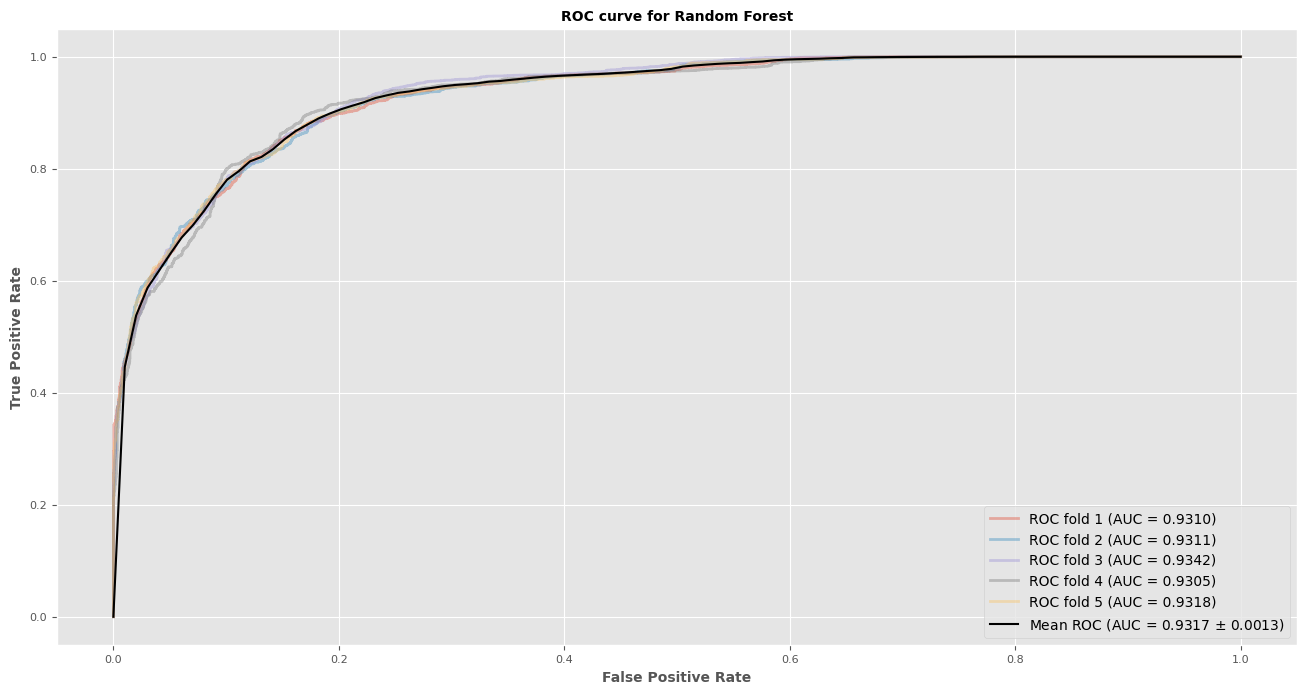

In [25]:
plot_ROC(rf, X_train, y_train, n_folds=5, plot_folds=True, stdev=False)
plt.title('ROC curve for Random Forest', fontweight='bold')
plt.show()

In [26]:
item = {'model': rf, 'accuracy': 0, 'precision': 0, 'recall': 0, 'f2': 0}
item['accuracy'] = accuracy_score(y_test, pred)
item['precision'] = precision_score(y_test, pred, pos_label='poisonous')
item['recall'] = recall_score(y_test, pred, pos_label='poisonous')
item['f2'] = fbeta_score(y_test, pred, beta=2, pos_label='poisonous')

models['Random Forest'] = item

# Comparison between models

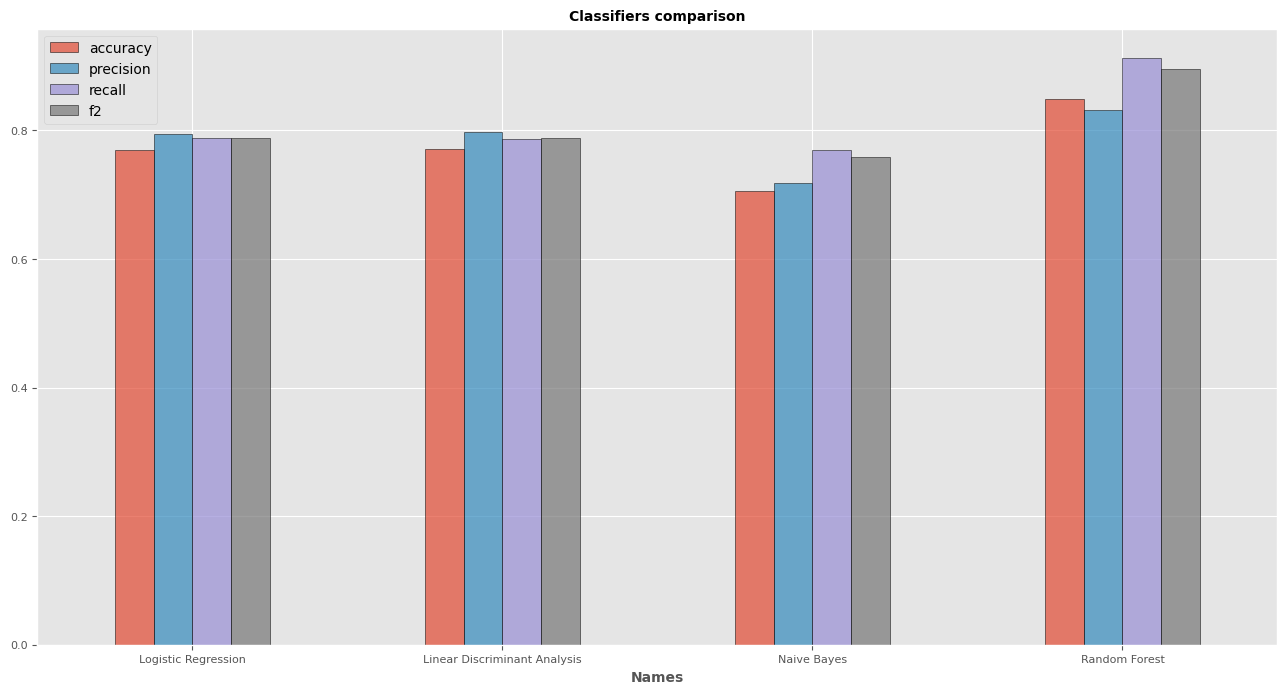

In [27]:
models_performances = pd.DataFrame.from_dict(models, orient='index')
models_performances = models_performances.drop(columns=['model'])
models_performances['Names'] = models_performances.index

cols = ['accuracy', 'precision', 'recall', 'f2']
models_performances.plot('Names', y=cols, kind='bar', stacked=False, edgecolor='black', alpha=0.7)
ax = plt.gca()
ax.set_xticklabels(models_performances['Names'], rotation=0)
plt.title('Classifiers comparison', fontweight='bold')
plt.show()

In [28]:
item = {'model': logreg, 'accuracy': 0, 'precision': 0, 'recall': 0, 'f2': 0}
item['accuracy'] = accuracy_score(y_test, pred)
item['precision'] = precision_score(y_test, pred, pos_label='poisonous')
item['recall'] = recall_score(y_test, pred, pos_label='poisonous')
item['f2'] = fbeta_score(y_test, pred, beta=2, pos_label='poisonous')

models['Logistic Regression'] = item

## Improving Random Forest performances

In [29]:
from sklearn.model_selection import RandomizedSearchCV
param_dist = {'n_estimators': [x for x in range(10, 200)],
              'max_depth': [i for i in range (40)]}

class_weight = {'edible': 4, 'poisonous': 6} # unbalanced class weights - poisonous are more important to detect

# Create a random forest classifier
rf_constrained = RandomForestClassifier(class_weight=class_weight, random_state=1000)

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf_constrained, 
                                 param_distributions = param_dist,  
                                 cv=5, random_state=1000)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)
best_params = rand_search.best_params_

Best hyperparameters: {'n_estimators': 145, 'max_depth': 24}


In [30]:
irf = RandomForestClassifier(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], random_state=1000)
irf.fit(X_train, y_train)
pred = irf.predict(X_test)
report = classification_report(y_test, pred)
print(f'Random Forest')
print(report)

Random Forest
              precision    recall  f1-score   support

      edible       1.00      1.00      1.00      5458
   poisonous       1.00      1.00      1.00      6756

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg       1.00      1.00      1.00     12214



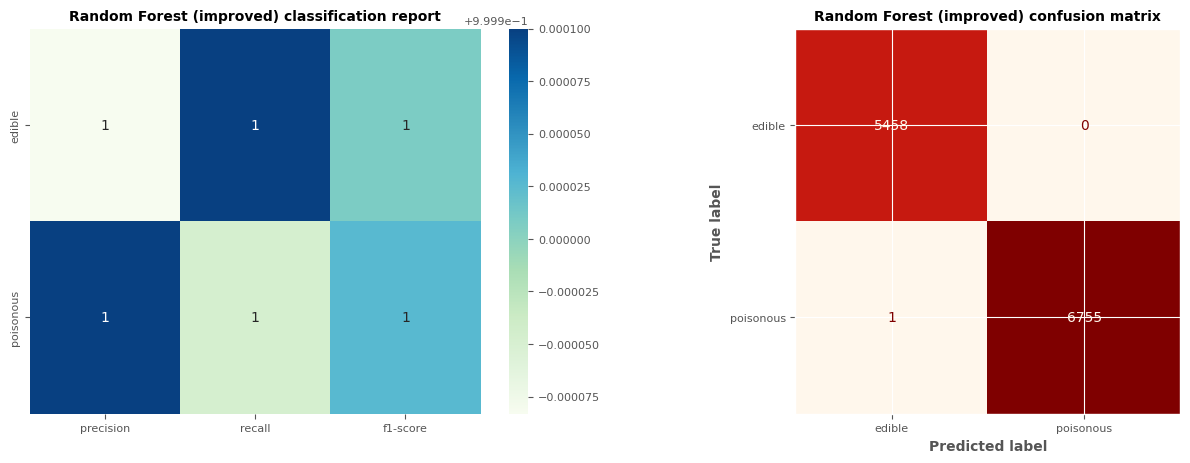

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

report = classification_report(y_test, pred, output_dict=True)
sns.heatmap(pd.DataFrame(report).iloc[:-1, :-3].T, annot=True, cmap="GnBu", ax=ax[0])
ax[0].set_title('Random Forest (improved) classification report', fontweight="bold")

ConfusionMatrixDisplay(confusion_matrix(y_test, pred), display_labels=['edible', 'poisonous']).plot(cmap='OrRd', ax=ax[1], colorbar=False)
ax[1].set_title('Random Forest (improved) confusion matrix', fontweight="bold")
plt.show()

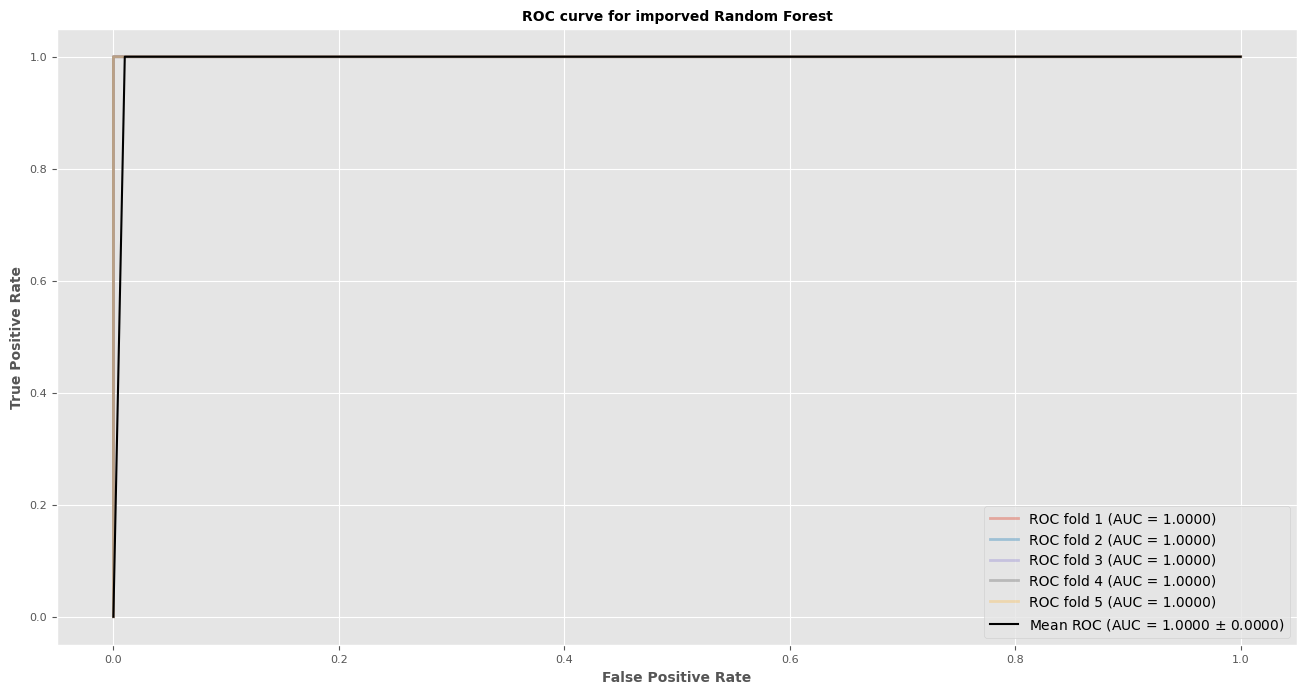

In [32]:
plot_ROC(irf, X_train, y_train, n_folds=5, plot_folds=True, stdev=False)
plt.title('ROC curve for imporved Random Forest', fontweight='bold')
plt.show()

# TODO: Reduce training set size

# Multi-Layer Perceptron Neural Network

In [33]:
from sklearn.neural_network import MLPClassifier
test_size = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=100)
n_features = X_train.shape[1]
mlp = MLPClassifier(hidden_layer_sizes=(n_features, 2*n_features, n_features), activation='relu', solver='adam', max_iter=500, random_state=1000)
mlp.fit(X_train, y_train)
pred = mlp.predict(X_test)
report = classification_report(y_test, pred)
print(f'Multilayer Perceptron')
print(report)

Multilayer Perceptron
              precision    recall  f1-score   support

      edible       1.00      1.00      1.00      5458
   poisonous       1.00      1.00      1.00      6756

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg       1.00      1.00      1.00     12214



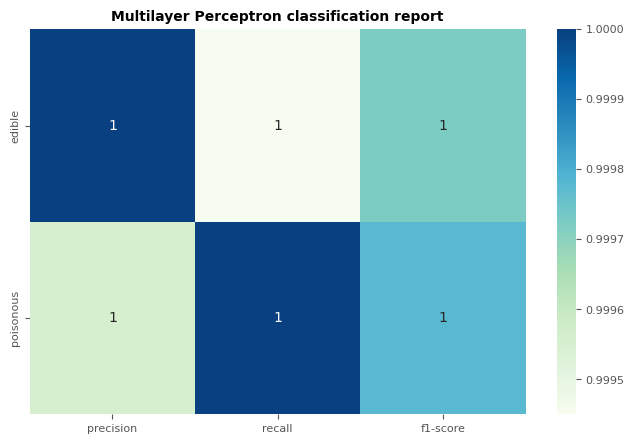

In [34]:
report = classification_report(y_test, pred, output_dict=True)
plt.figure(figsize=(8,5))
sns.heatmap(pd.DataFrame(report).iloc[:-1, :-3].T, annot=True, cmap="GnBu")
plt.title('Multilayer Perceptron classification report', fontweight="bold")
plt.show()

In [75]:
n_features = X_train.shape[1]
param_random = {
    'hidden_layer_sizes': [(2 *n_features)],
    'max_iter': [100],
    'activation': ['relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['adaptive'],
}

mlp_clf = MLPClassifier(random_state=1000)
grid = RandomizedSearchCV(mlp_clf, param_random, n_jobs= -1, cv=5)
grid.fit(X_train, y_train)

print(grid.best_params_) 

{'solver': 'adam', 'max_iter': 100, 'learning_rate': 'adaptive', 'hidden_layer_sizes': 184, 'alpha': 0.0001, 'activation': 'relu'}


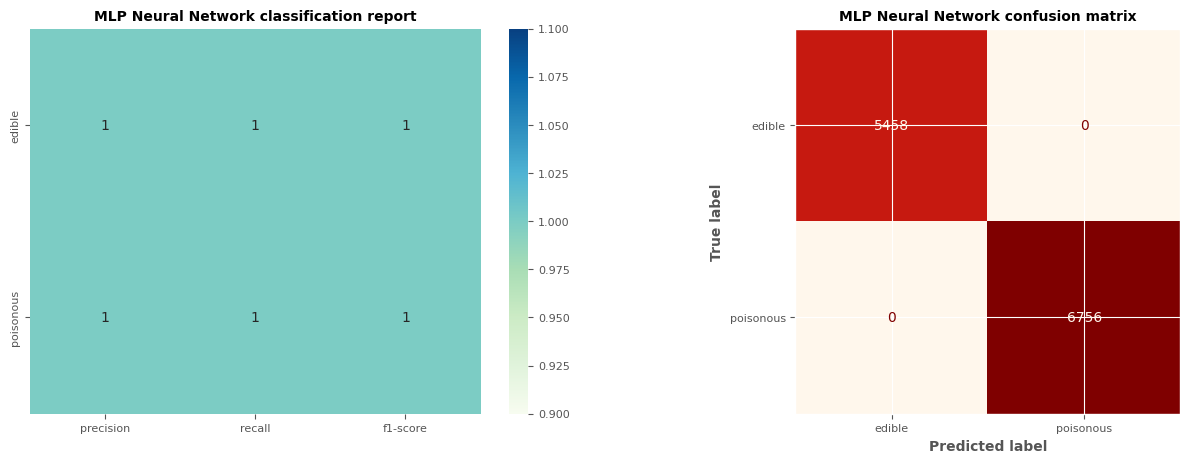

In [76]:
grid_predictions = grid.predict(X_test)
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

report = classification_report(y_test, grid_predictions, output_dict=True)
sns.heatmap(pd.DataFrame(report).iloc[:-1, :-3].T, annot=True, cmap="GnBu", ax=ax[0])
ax[0].set_title('MLP Neural Network classification report', fontweight="bold")

ConfusionMatrixDisplay(confusion_matrix(y_test, grid_predictions), display_labels=['edible', 'poisonous']).plot(cmap='OrRd', ax=ax[1], colorbar=False)
ax[1].set_title('MLP Neural Network confusion matrix', fontweight="bold")
plt.show()

## K-Nearest Neighbors

In [55]:
from sklearn.neighbors import KNeighborsClassifier

test_size = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=100)

ks = [3, 9, 27, 81, 243, 729, 2187, 6561, 19683]
accuracies = []
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    report = classification_report(y_test, pred)
    accuracies.append(accuracy_score(y_test, pred))
    print(f'{k}-Nearest Neighbors')
    print(report)

3-Nearest Neighbors
              precision    recall  f1-score   support

      edible       1.00      1.00      1.00      5458
   poisonous       1.00      1.00      1.00      6756

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg       1.00      1.00      1.00     12214

9-Nearest Neighbors
              precision    recall  f1-score   support

      edible       1.00      1.00      1.00      5458
   poisonous       1.00      1.00      1.00      6756

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg       1.00      1.00      1.00     12214

27-Nearest Neighbors
              precision    recall  f1-score   support

      edible       1.00      1.00      1.00      5458
   poisonous       1.00      1.00      1.00      6756

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg 

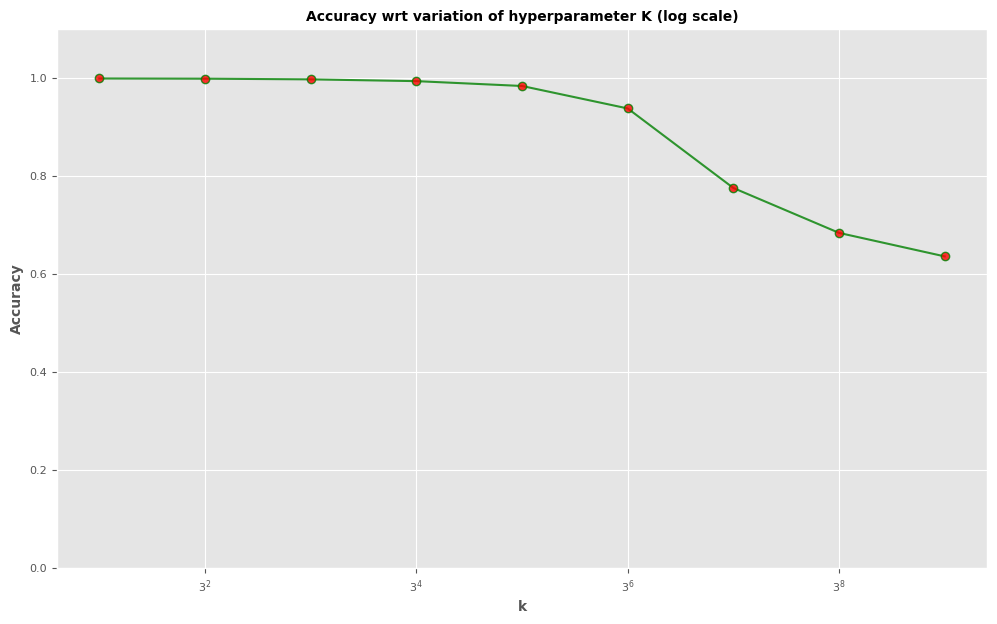

In [77]:
plt.figure(figsize=(12,7))
plt.plot(ks, accuracies, marker='o', color='green', mfc="red", alpha=.8 ,linewidth=1.5, markersize=6)
plt.title('Accuracy wrt variation of hyperparameter K (log scale)', fontweight="bold")
plt.xticks(ks)
plt.xlabel('k')
ax = plt.gca()
ax.set_xscale('log', base=3)
plt.ylim(0, 1.1)
plt.ylabel('Accuracy')
plt.show()